
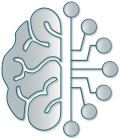

**Start at:** Thursday 16 November 2023, 12:42:40  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, bg, hl
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

#cancel the "last operation show-up" specific of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Parametrized tight-binding for calculating a material's energy and electronic structure

## Introduction

### The tight-binding method

<div class="intro">
    
The tight binding (TB) method is an approximate approach for solving for the electronic wave functions for electrons in solids assuming a basis of localized atomic-like orbitals. This model is applicable to a wide variety of systems and phenomena in quantum physics. The approach does not require computing from first principles, but instead simply uses parameterized matrix elements. In contrast to *ab initio* or DFT calculations, the tight-binding model can scale to large system sizes on the order of millions of atoms. 

TB calculations proposed in this notebook will be done with [**pybinding**](https://docs.pybinding.site/en/stable/). It is a scientific Python package for numerical tight-binding calculations in solid state physics.

The orbitals are assumed to be orthonormal, pybinding focuses on the “empirical tight binding” approach in which the Hamiltonian matrix elements are simply parametrized.
</div>
<br>
<div class="rq">

This package actually does simple Hückel calculations, but with periodic boundary conditions. It can also do molecular calculations. The Hückel electron-hopping parameter, named $\beta$ in the chemistry realm, is often referred to as $t$ in solid-state physics, $t$ meaning *transfer*. It is also called the bond energy or two center integral and it is the dominant term in the tight binding model.
</div>

### The band structure of solids and the Fermi level

<div class="intro">

Before playing with a TB package, it is necessary to remind that in the [band theory of solids](https://en.wikipedia.org/wiki/Fermi_level), electrons are considered to occupy a series of bands composed of single-particle energy eigenstates each labelled by &varepsilon;. Although this single particle picture is an approximation, it greatly simplifies the understanding of electronic behaviour and it generally provides correct results when applied correctly.

The Fermi–Dirac distribution gives the probability that, at thermodynamic equilibrium, a state having energy &varepsilon; is occupied by an electron:

$$f(\epsilon)=\frac{1}{1+\exp\left(\frac{\epsilon-\mu}{k_{\mathrm{B}}T}\right)}$$

where *k*<sub>B</sub> is the Boltzmann constant, *T* is the absolute temperature and *&mu;* is the total chemical potential.

At finite temperatures there is no sharply defined most energetic electron because thermal energy is continuously exciting electrons within the bands. It is possible to define an energy level with an arbitrary 50% probability of occupation, and this is the Fermi level, sometimes called Fermi energy, whereas the actual Fermi energy is defined at *T*=0K. Some examples are reported below, for different materials. 

<figure>
  <img width = "600px" src="MiscImages/TB/Band_filling_diagram.svg" alt="band structure of solids" />
  <figcaption><b>Density of states and filling of the electronic states in various types of materials at equilibrium at <i>T</i> &ne; 0K</b><br>(from <a href="https://en.wikipedia.org/wiki/Fermi_level">Wikipedia</a>)</figcaption>
</figure>

</div>



## Doing a TB calculation with pybinding: workflow

<div class="intro">

The general workflow starts with the definition of a model. The crystal lattice and the system geometry are the two main main parts required to describe a tight-binding model.

Once the model description is complete, pybinding will build the tight-binding Hamiltonian matrix. The next step is to apply computations to the matrix to obtain the values of the desired quantum properties. To that end, there are the following possibilities: Kernel polynomial method, exact diagonalization, or a user-defined solver

After the main computation is complete, various utility functions are available for post-processing the raw result data. The included plotting functions are tailored for tight-binding problems to help visualize the model structure and to make sense of the results

</div>

### Lattice and geometry specification

<div class="introT" title="The crystal lattice">

This step includes the specification of the primitive lattice vectors and the configuration of the unit cell (atoms, orbitals, TB parameters and spins). This can be user-defined, but the package also contains a repository of the pre-made specifications for several materials.
</div>
<br>
<div class="introT" title="System geometry">

The model system can be infinite through the use of translational symmetry or it can be finite by specifying a shape. 
</div>

<div class="rqT" title="first install the development version of the pybinding package">

It can be done with pip. Uncomment the next line the first time you use this notebook
</div>

In [2]:
# %pip install -i https://test.pypi.org/simple/ pybinding

In [3]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

pb.pltutils.use_style() # applies pybinding’s default style settings for matplotlib

d = 0.1  # [nm] unit cell length
t = -1   # [eV] hopping energy

# create a simple 1D lattice with vector a1
lattice = pb.Lattice(a1=[d, 0], a2=[0, d])
lattice.add_sublattices(
    ('A', [0, 0], 0.)  # add an atom called 'A' at position [0, 0] and set its associated AO energy to 0 eV
)
lattice.add_hoppings(
    # (Difference of the indices of the source and destination unit cells
    # Name of the sublattice in the source unit cell, Name of the sublattice in the destination unit cell, hopping energy)
    ([0, 1], 'A', 'A', t),
    ([1, 0], 'A', 'A', t)
)

<div class="rq"'>
    
It may not be immediately obvious what this code does. Fortunately, [`Lattice`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice) objects have a convenient [`Lattice.plot()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.plot) method to easily visualize the constructed lattice.
</div>

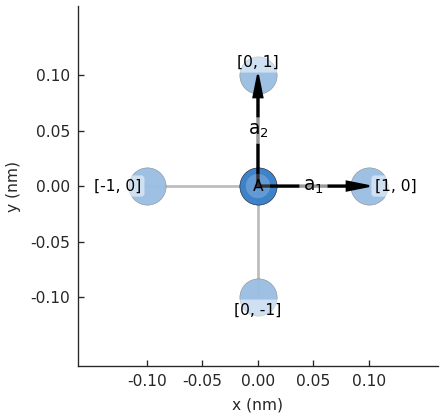

In [4]:
lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function

<div class="rq">

In the figure we see lattice vectors $a_1$ and $a_2$ which were used to initialize [`Lattice`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice). These vectors describe a Bravais lattice with an infinite set of positions,

$$
\vec{R} = n_1 \vec{a}_1 + n_2 \vec{a}_2,
$$

where $n_1$ and $n_2$ are integers. The blue circle labeled A represents the atom which was created with the [`Lattice.add_sublattices()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.add_sublattices) method. The slightly faded out circles represent translations of the lattice in the primitive vector directions, i.e. using the integer index $[n_1, n_2]$.

The hoppings are specified using the [`Lattice.add_hoppings()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.add_hoppings) method and each one consists of `(relative_index, from_sublattice, to_sublattice, energy)`:

* The main cell always has the index $[n_1, n_2]$ = [0, 0]. The `relative_index` represents the number of integer steps needed to reach another cell starting from the main one. Each cell is labeled with its `relative_index`, as seen in the figure.
  
* A hopping is created between the main cell and a neighboring cell specified by `relative_index`. Two hoppings are added in the definition: [0, 1] and [1, 0].

* The opposite hoppings [0, -1] and [-1, 0] are added automatically to maintain translational symmetry.
  
* This lattice consists of only one sublattice so the `from` and `to` sublattice fields are trivial. Generally, `from_sublattice` indicates the sublattice in the [0, 0] cell and `to_sublattice` in the neighboring cell. This will be explained further in the next example.
  
* The last parameter is simply the value of the hopping energy.
  
It’s good practice to build the lattice inside a function to make it easily reusable. Here we define the same lattice as before, but note that the unit cell length and hopping energy are function arguments, which makes the lattice easily configurable.
</div>
<br>
<div class="intro">

The defined square is the primitive of the tetragonal 2D [Bravais lattice](https://en.wikipedia.org/wiki/Bravais_lattice), see figure below (*a* = *b* and &theta; = 90°). Let's recall that a primitive cell is a unit cell that contains exactly one lattice point. 
<img width="150" src="./MiscImages/TB/SQL.svg" style="display:block; margin-left:auto; margin-right:auto" id="SQL"/> 

This is the case here, since each atom is shared by 4 cells, it is counted as 1/4. 4 atoms x 1/4 = 1.
 
</div>

<div class="intro">

It is even possible to plot the **[Brillouin zone](https://en.wikipedia.org/wiki/Brillouin_zone)**. The [reciprocal lattice vectors](https://en.wikipedia.org/wiki/Reciprocal_lattice) **b<sub>1</sub>** and **b<sub>2</sub>** are calculated automatically based on the real space vectors. There is no need to specify them manually. The first Brillouin zone is determined as the Wigner–Seitz cell in reciprocal space. By default, the plot method labels the vertices of the Brillouin zone.
</div>

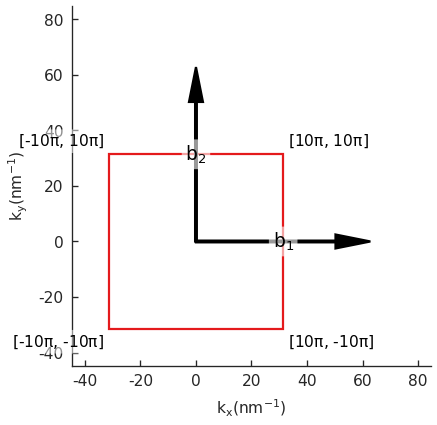

In [5]:
lattice.plot_brillouin_zone()

### Setting up a band structure calculation

<div class="intro">

In order to calculate the band structure of a crystal lattice, this section introduces the concepts of a [`Model`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model) and a [`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver).

A [`Model`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Model.html#pybinding.Model) contains the full tight-binding description of the physical system that we wish to solve. We’ll now assign the previous lattice to the model.
</div>

#### Definition of the model

<1x1 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

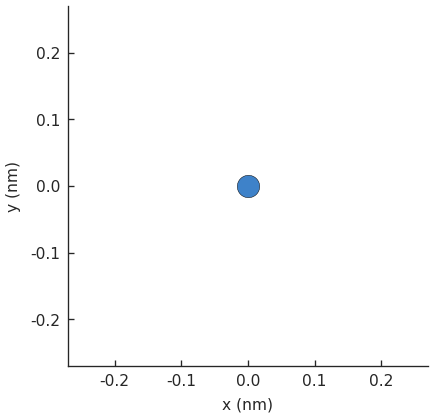

In [6]:
model = pb.Model(
    lattice,  # predefined lattice from the material repository
)

model.hamiltonian
model.plot()

<div class="rq">

It’s a sparse matrix (see [`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)) which corresponds to the tight-binding Hamiltonian of our model. The output above shows the default sparse representation of the data where each line corresponds to `(row, col) value`. Alternatively, we can see the dense matrix output:
</div>

In [7]:
model.hamiltonian.todense()

matrix([[0.]], dtype=float32)

<div class="introT" title="Set up of an infinite 2D sheet">

Next, we include [`translational_symmetry()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.translational_symmetry.html#pybinding.translational_symmetry) to create an infinite graphene sheet.
</div>

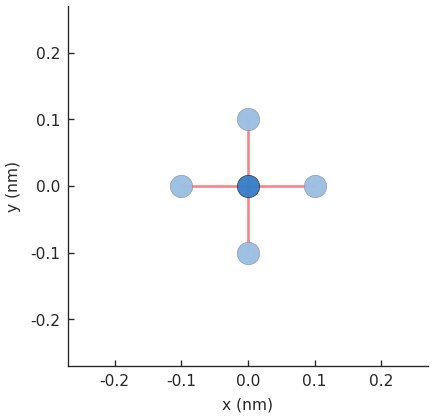

In [8]:
model = pb.Model(
    lattice,
    pb.translational_symmetry()
)
model.plot()

<div class="rq">

The red lines indicate hoppings on periodic boundaries. The lighter colored circles represent the translations of the unit cell. The number of translations is infinite, but the plot only presents the first one in each lattice vector direction.
</div>

#### Solver

<div class="intro">

A [`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver) can exactly calculate the eigenvalues and eigenvectors of a Hamiltonian matrix. Although there are various [Eigenvalue solvers](http://docs.pybinding.site/page/tutorial/solvers.html) in pybinding, right now we’ll just use the [`lapack()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.lapack) solver which is the simplest and most appropriate for small systems.

A great advantage of this solver is that it always solves for **all** eigenvalues and eigenvectors of a Hamiltonian matrix.
</div>

array([[1.+0.j]], dtype=complex64)

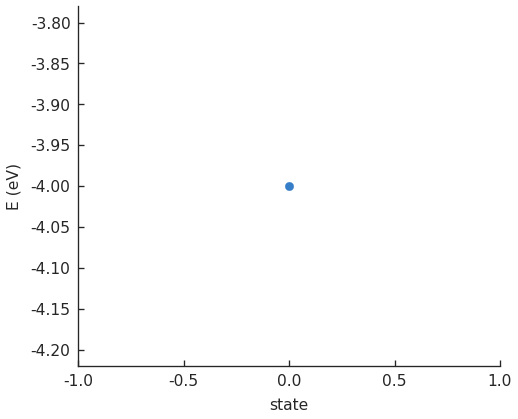

In [9]:
solver = pb.solver.lapack(model)
eigenvalues = solver.calc_eigenvalues()
eigenvectors = solver.eigenvectors

eigenvalues
eigenvectors

eigenvalues.plot()

## Infinite chain of equally spaced H atoms

### "Equilibrium" lattice parameters

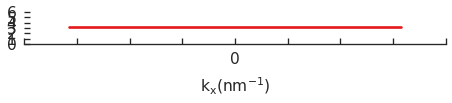

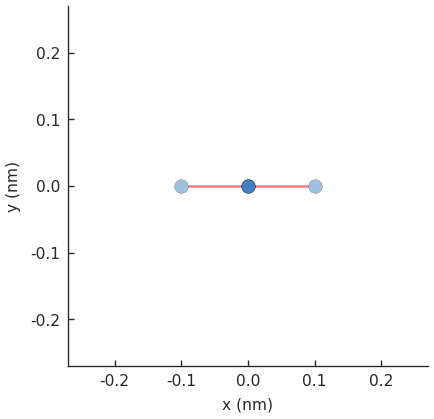

In [10]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

pb.pltutils.use_style() # applies pybinding’s default style settings for matplotlib

def Hchain_lattice(a=0.1,t=-1.0):
    # create a simple 1D lattice with vector a1
    lattice = pb.Lattice(a)
    lattice.add_one_sublattice('H', [0])
    lattice.add_one_hopping([1], 'H', 'H', t)
    return lattice
    
aH = 0.1   # [nm] unit cell length
tH = -1.0   # [eV] hopping energy

Hlattice = Hchain_lattice(aH,tH)

# single atom definition cannot be plotted
# Hlattice.plot()  # plot the lattice that was just constructed
# plt.show()      # standard matplotlib show() function
Hlattice.plot_brillouin_zone()
plt.show()

Hmodel = pb.Model(
    Hlattice,
    pb.translational_symmetry()
)
Hmodel.plot()
plt.show()

In [11]:
Hmodel.hamiltonian
Hsolver = pb.solver.lapack(Hmodel)
eigenvalues = Hsolver.calc_eigenvalues()
eigenvectors = Hsolver.eigenvectors

eigenvalues
eigenvectors

<1x1 sparse matrix of type '<class 'numpy.complex64'>'
	with 1 stored elements in Compressed Sparse Row format>

array([[1.+0.j]], dtype=complex64)

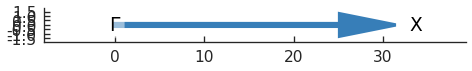

In [12]:
from math import pi

Gamma = [0, 0]
X = [pi/aH, 0]
kpoints_labels = [f'$\Gamma$', 'X']
Hbands = Hsolver.calc_bands(Gamma, X)

Hbands.plot_kpath(point_labels=kpoints_labels)

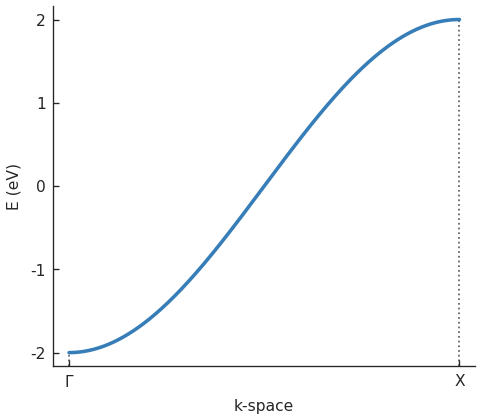

In [13]:
Hbands.plot(point_labels=kpoints_labels)

<div class="rq">

This is exactly what can be found in textbooks, such as in the remarkable *Solids And Surfaces. A Chemist's View of Bonding in Extended Structures*, by R. Hoffmann (Wiley, 1988).
<figure>
  <img width = "40%" src="MiscImages/TB/Hoffmann-Hchain-p7.png" alt="H chain" />
  <figcaption >(from R. Hoffmann, <i>A Chemist's View of Bonding in Extended Structures</i>, &copy; Wiley 1991)</figcaption>
</figure>

This band is nothing else than the Fermi level, *i.e.* the HOMO. 
</div>

### Increase of the lattice parameter, band width

<div class="intro">

With a simple tight-binding model, it mainly consists in decreasing the hopping integral, *t*. The lattice paramer, *a*, is decreased as well for plotting purposes, but since *t* does not depend on *a*, changing this parameter has no impact.
</div>

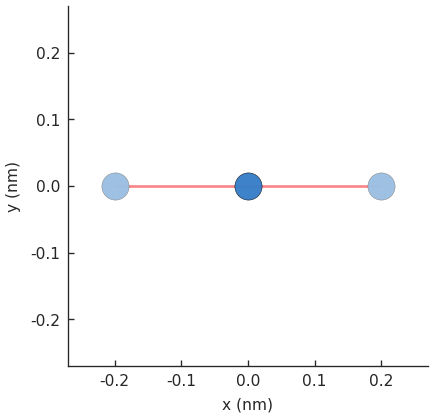

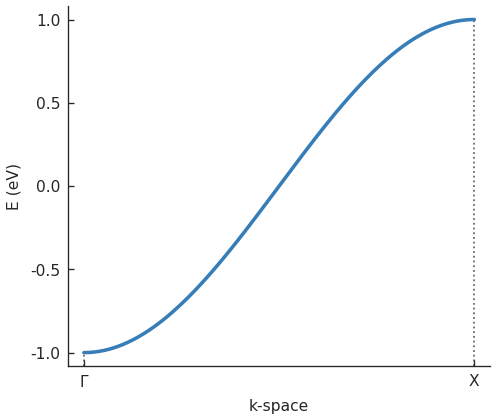

In [14]:
aH2 = 2*aH
tH2 = tH/2

Hlattice2 = Hchain_lattice(aH2,tH2)
Hmodel2 = pb.Model(
    Hlattice2,
    pb.translational_symmetry()
)
Hmodel2.plot()
plt.show()

Hsolver2 = pb.solver.lapack(Hmodel2)

Gamma = [0, 0]
X = [pi/aH2, 0]
Hbands2 = Hsolver2.calc_bands(Gamma, X)

Hbands2.plot(point_labels=kpoints_labels)
plt.show()

<div class="rq">

Compare it to the previous band structure, and to the next picture.
<figure>
  <img width = "40%" src="MiscImages/TB/Hoffmann-HchainBW-p8.png" alt="band width in a H chain" />
  <figcaption >(from R. Hoffmann, <i>A Chemist's View of Bonding in Extended Structures</i>, &copy; Wiley 1991)</figcaption>
</figure>

</div>

### More than one AO in the unit cell

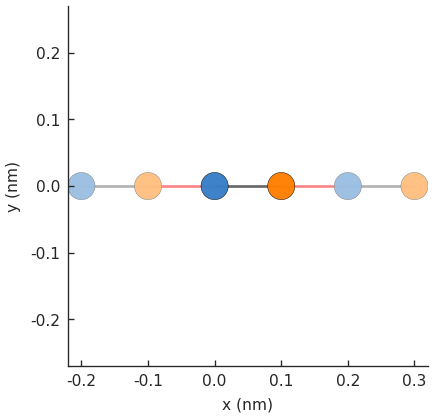

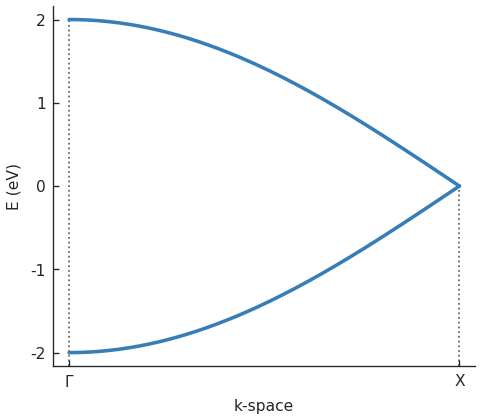

In [15]:
aH2 = 2*aH
tH2 = tH

def H2chain_lattice(a=2.0,t=-1.0):
    # create a simple 1D lattice with vector a1
    lattice = pb.Lattice(a)
    lattice.add_one_sublattice('Ha', 0.0)
    lattice.add_one_sublattice('Hb', a/2)
    lattice.add_one_hopping([0,0], 'Ha', 'Hb', t)
    lattice.add_one_hopping([1,0], 'Hb', 'Ha', t)
    return lattice

H2lattice = H2chain_lattice(aH2,tH2)
H2model = pb.Model(
    H2lattice,
    pb.translational_symmetry()
)
H2model.plot()
plt.show()

H2solver = pb.solver.lapack(H2model)

Gamma = [0, 0]
X = [pi/aH2, 0]
H2bands = H2solver.calc_bands(Gamma, X)

H2bands.plot(point_labels=kpoints_labels)
plt.show()

<div class="rq">

This is again exactly whats is found in textbooks.
<figure>
  <img width = "50%" src="MiscImages/TB/Hoffmann-H2chain-p90.png" alt="H2 chain" />
  <figcaption >(from R. Hoffmann, <i>A Chemist's View of Bonding in Extended Structures</i>, &copy; Wiley 1991)</figcaption>
</figure>

There are two bands now, due to the enlargement of the unit cell. But it does not change anything to the increase of the energy of the band as a function of the *k*, and the nature a state &Psi;(*k*) does not change. 

And the Fermi energy is still 0, with two electrons occupying the lowest band.
</div>

### 1D alternating chain band structure, the Peierls distortion

<div class="intro">

It is the solid-state counterpart of the Jahn-Teller effect. It will occur for systems where a symmetry-lowering deformation will break a degeneracy or quasi-degeneracy of states, provided that it  stabilizes the compound. Let's see how it works on an unsymmetrical chain of hydrogen atoms. Stabilization can be achieved with a distorted hydrogen chain, *i.e.* the hydrogen atoms are in pair. 
</div>

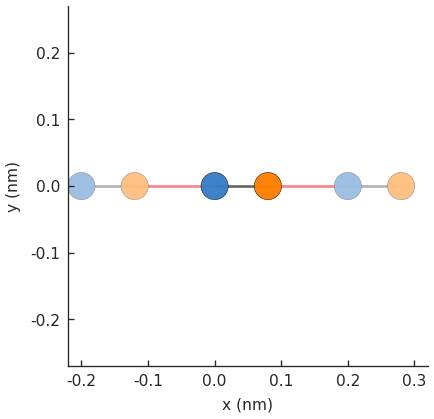

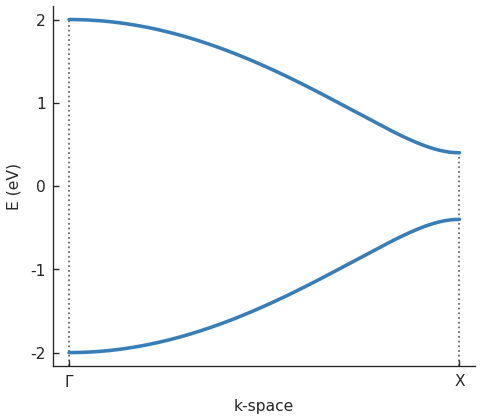

In [16]:
aH2 = 2*aH
tH2 = tH

def H2Dchain_lattice(a=0.2,t=-1.0):
    # create a simple 1D lattice with vector a1
    lattice = pb.Lattice(a)
    lattice.add_one_sublattice('Ha', 0.0)
    lattice.add_one_sublattice('Hb', 0.8*a/2)
    lattice.add_one_hopping([0,0], 'Ha', 'Hb', 1.2*t)
    lattice.add_one_hopping([1,0], 'Hb', 'Ha', 0.8*t)
    return lattice

H2Dlattice = H2Dchain_lattice(aH2,tH2)
H2Dmodel = pb.Model(
    H2Dlattice,
    pb.translational_symmetry()
)
H2Dmodel.plot()
plt.show()

H2Dsolver = pb.solver.lapack(H2Dmodel)

Gamma = [0, 0]
X = [pi/aH2, 0]
H2Dbands = H2Dsolver.calc_bands(Gamma, X)

H2Dbands.plot(point_labels=kpoints_labels)
plt.show()

<div class="rq">

It is exactly what you can find p. 101 of Hoffmann's book. A stabilization of the system occurs at the Fermi level for any *k*. It is maximal for the half-filled band, *i.e.* at &pi;/(2*a*). The scheme on the right highlights the band gand opening at the Fermi energy.
<figure>
  <img width = "50%" src="MiscImages/TB/Hoffmann-H2distorted_chain-p101.png" alt="distorted H2 chain" />
  <figcaption >(from R. Hoffmann, <i>A Chemist's View of Bonding in Extended Structures</i>, &copy; Wiley 1991)</figcaption>
</figure>
</div>

## 2D square lattice

### Definition of the primitive lattice model

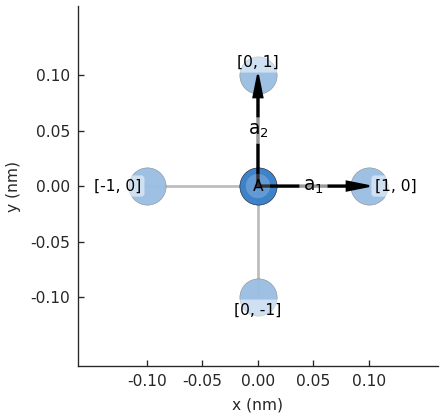

In [17]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

pb.pltutils.use_style() # applies pybinding’s default style settings for matplotlib

def square_lattice(a=0.1, t=-1.):
    '''
    input:
        - a = lattice parameter, in nm (default: 2 angs = 0.2 nm)
        - t = hopping energy, in eV (default : -1 eV)
    '''
    
    # create a simple 2D lattice with vectors a1 & a2
    lattice = pb.Lattice(a1=[a, 0], a2=[0, a])
    lattice.add_sublattices(
        ('A', [0, 0], 0.)  # add an atom called 'A' at position [0, 0] and set its associated AO energy to 0 eV
    )
    lattice.add_hoppings(
        # (Difference of the indices of the source and destination unit cells
        # Name of the sublattice in the source unit cell, Name of the sublattice in the destination unit cell, hopping energy)
        ([0, 1], 'A', 'A', t),
        ([1, 0], 'A', 'A', t)
    )
    return lattice

aSQL = 0.1
tSQL = -1.
SQL = square_lattice(aSQL,tSQL)
SQL.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function

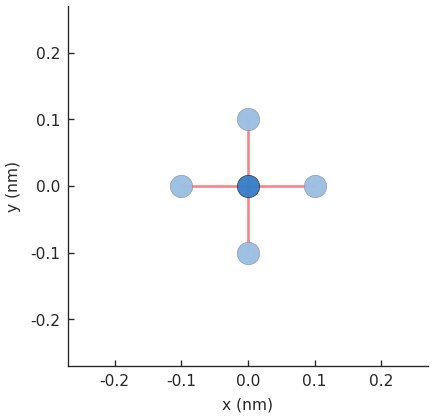

In [18]:
SQLmodel = pb.Model(
    SQL,
    pb.translational_symmetry()
)
SQLmodel.plot()

<div class="rqT" title="Reminder">

This is a useful representation for checking that the system has been correctly defined using the  add_sublattices` and `add_hoppings` functions, given that:
- The red lines indicate hoppings on periodic boundaries
- The lighter colored circles represent the translations of the unit cell
- The plot only presents the first one in each lattice vector direction
</div>

### Brillouin zone (BZ)

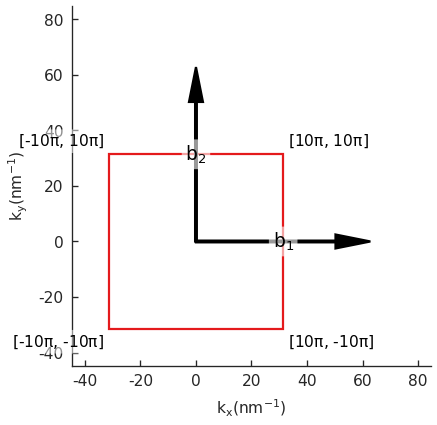

In [19]:
SQL.plot_brillouin_zone()

<div class="rq">

- The Brillouin zone (BZ) is a square spanned by two vectors **b**<sub>1</sub> and **b**<sub>2</sub>
- Their norm is &pi;/*a* (with *a* = lattice parameter)
- This gives the allowed space of *k*: *k*<sub>1</sub>: [0,&pi;/*a*] and *k*<sub>2</sub>: [0,&pi;/*a*]
- Certain special values of *k* have given names:
    - &Gamma;: [0,0]. It is the BZ center
    - X: [&pi;/*a*,0]) = [0,&pi;/*a*]
    - M: [&pi;/*a*,&pi;/*a*]
</div>
<br>
<div class="intro">

Let's now visualize these special points on the BZ plot. It can be done by calculating the energy levels of the system. 

[`Solver`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver) has a convenient [`calc_bands()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.calc_bands) method which can be used to calculate the band structure of our model

The points $\Gamma, X$ and $M$ are used to draw a path in the reciprocal space of graphene’s Brillouin zone and [`Solver.calc_bands()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.solver.html#pybinding.solver.Solver.calc_bands) calculates the band energy along that path. The return value of the method is a [`Bands`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands) result object.

All result objects have built-in plotting methods. Aside from the basic [`plot()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands.plot) seen above, [`Bands`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands) also has [`plot_kpath()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Bands.html#pybinding.Bands.plot_kpath) which presents the path in reciprocal space. Plots can easily be composed, so to see the path in the context of the Brillouin zone, we can simply plot both:
</div>

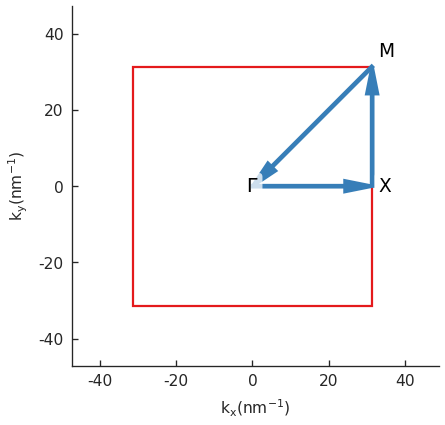

In [20]:
from math import pi
Gamma = [0, 0]
X = [pi/aSQL, 0]
M = [pi/aSQL,pi/aSQL]

solverSQL = pb.solver.lapack(SQLmodel)
SQLbands = solverSQL.calc_bands(Gamma, X, M, Gamma)

SQLmodel.lattice.plot_brillouin_zone(decorate=False)
kpoints_labels = [f'$\Gamma$', 'X', 'M', f'$\Gamma$']
SQLbands.plot_kpath(point_labels=kpoints_labels)

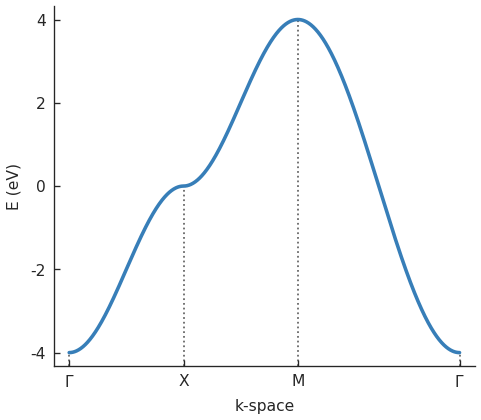

In [21]:
SQLbands.plot(point_labels=kpoints_labels)
plt.savefig("./FiguresCreatedInNotebooks/HSquareLattice.png",dpi=300, transparent=True)
plt.show()

<div class="rq">

M has the highest energy wavefunction and X seems pretty much nonbonding, given its energy. Needless to say that it is again a textbook case:

<figure>
  <img width = "55%" src="MiscImages/TB/Hoffmann-SquareLattice-BandStructure.png" alt="square lattice" />
  <figcaption >(from R. Hoffmann, <i>A Chemist's View of Bonding in Extended Structures</i>, &copy; Wiley 1991)</figcaption> 
</figure>
</div>

### 2 &times; 2 square unitcell

<div class="intro">

A primitive cell is the smallest unit cell of a crystal. For the 2D square lattice, this is the usual 1-atom cell. It’s translated in space to construct a larger system. Sometimes it can be convenient to use a larger unit cell instead, i.e. a supercell consisting of multiple primitive cells.

A 2x2 multiple cell is a 4-atom cell. It can be created by adding three more sublattices to the `Lattice` specification
</div>

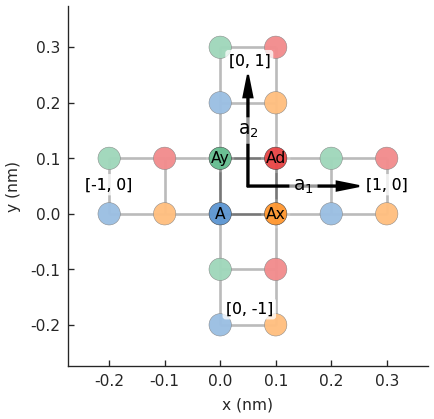

In [22]:
def square_lattice22(a=0.2, t=-1.):
    '''
    input:
        - a = lattice parameter, in nm (default: 2 angs = 0.2 nm)
        - t = hopping energy, in eV (default : -1 eV)
    '''
    
    # create a simple 2D lattice with vectors a1 & a2
    lattice = pb.Lattice(a1=[a, 0], a2=[0, a])
    lattice.add_sublattices(
        ('A', [0, 0], 0.),  # add an atom called 'A' at position [0, 0] and set its associated AO energy to 0 eV
        ('Ax', [a/2, 0], 0.),
        ('Ay', [0, a/2], 0.),
        ('Ad', [a/2, a/2], 0.)
    )
    lattice.add_hoppings(
        # (Difference of the indices of the source and destination unit cells
        # Name of the sublattice in the source unit cell, Name of the sublattice in the destination unit cell, hopping energy)
        # inside the unit cell
        ([0, 0], 'A', 'Ax', t),
        ([0, 0], 'A', 'Ay', t),
        ([0, 0], 'Ax', 'Ad', t),
        ([0, 0], 'Ay', 'Ad', t),
        # between neighbouring unit cells
        ([1, 0], 'Ax', 'A', t),
        ([1, 0], 'Ad', 'Ay', t),
        ([0, 1], 'Ay', 'A', t),
        ([0, 1], 'Ad', 'Ax', t)
    )
    return lattice

aSQL22 = 0.2
tSQL = -1.
SQL22 = square_lattice22(aSQL22,tSQL)
SQL22.plot()  
plt.show()     

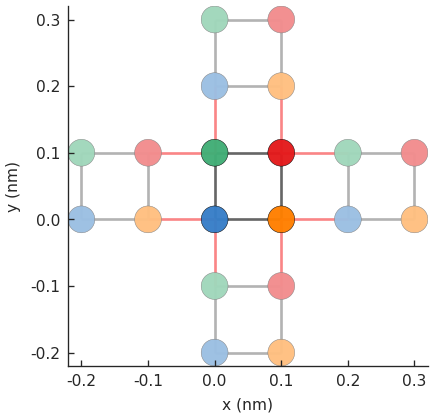

In [23]:
SQL22model = pb.Model(
    SQL22,
    pb.translational_symmetry(a1=True,a2=True)
)
SQL22model.plot()

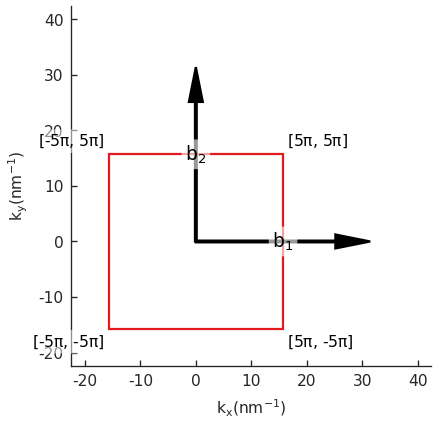

In [24]:
SQL22.plot_brillouin_zone()

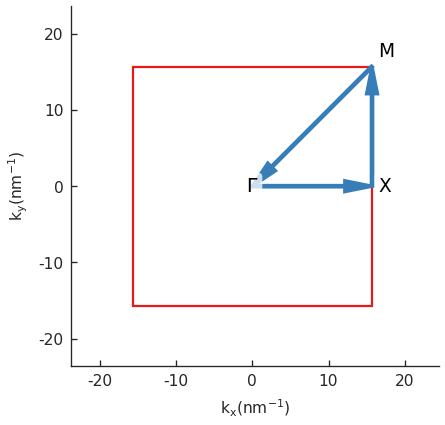

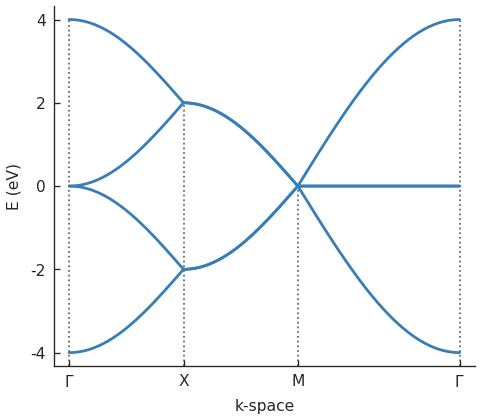

In [25]:
from math import pi

Gamma = [0, 0]
X = [pi/(aSQL22), 0]
M = [pi/(aSQL22),pi/(aSQL22)]

solverSQL22 = pb.solver.lapack(SQL22model)

SQL22bands = solverSQL22.calc_bands(Gamma, X, M, Gamma)

SQL22model.lattice.plot_brillouin_zone(decorate=False)
kpoints_labels = [f'$\Gamma$', 'X', 'M', f'$\Gamma$']
SQL22bands.plot_kpath(point_labels=kpoints_labels)
plt.show()

SQL22bands.plot(point_labels=kpoints_labels)
plt.savefig("./FiguresCreatedInNotebooks/HSquareLattice2x2.png",dpi=300, transparent=True)
plt.show()


<div class="rq">

You can compare it with the band structure of the primitive square unit cell, reported below. Comment?

<figure>
  <img width = "40%" src="FiguresCreatedInNotebooks/HSquareLattice-C.png" alt="BSprimitiveSquareLattice" />
  <figcaption ><b>Band structure of the primitive square unit cell</b></figcaption> 
</figure>
</div>

array([[-5.0000018e-01-0.j,  0.0000000e+00+0.j,  7.0710665e-01+0.j,
         4.9999997e-01-0.j],
       [-5.0000000e-01+0.j,  7.0710671e-01+0.j, -4.2146873e-08+0.j,
        -5.0000006e-01+0.j],
       [-4.9999994e-01+0.j, -7.0710677e-01+0.j, -4.2146869e-08+0.j,
        -5.0000000e-01+0.j],
       [-4.9999979e-01+0.j,  1.1920929e-07+0.j, -7.0710683e-01+0.j,
         4.9999997e-01+0.j]], dtype=complex64)

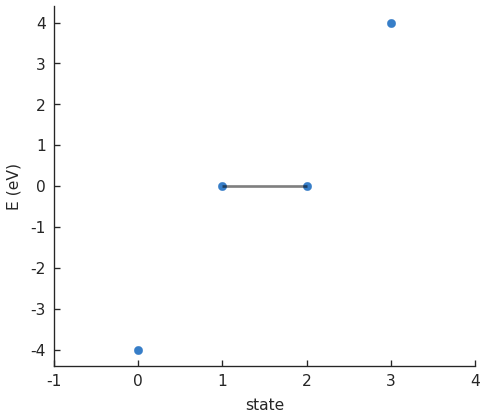

In [26]:
eigenvalues = solverSQL22.calc_eigenvalues()
eigenvectors = solverSQL22.eigenvectors

eigenvalues
eigenvectors

eigenvalues.plot()

### 2 &times; 2 rectangle unit cell

<div class="exE">

**1.** Define the 2 &times; 2 unit cell of a rectangular lattice of hydrogen atoms, with:
- *a*<sub>1</sub> = 0.16 nm
- *a*<sub>2</sub> = 0.24 nm
- *t*<sub>1</sub> = 1.2 eV
- *t*<sub>2</sub> = 0.8 eV

**2.** Calculate the band structure: 
- **2a.** visualize the following special *k*-points on the BZ plot
    - &Gamma;: [0, 0]
    - X<sub>1</sub>: [*a*<sub>1</sub>/2, 0]
    - M: [*a*<sub>1</sub>/2, *a*<sub>2</sub>/2]
    - X<sub>2</sub>: [0, *a*<sub>2</sub>/2]
- **2b.** plot the band structure for the same *k*-points

</div>

In [27]:
# insert your code here



<div class="sol">

Want to see a possible answer? Uncomment the `# %load ./SolutionsToExercises/...` command below, and then run the cell
</div>

In [28]:
# %load ./SolutionsToExercises/TB/RL22.py

<div class="rq">

You can compare it with the band structure of the 2 &times; 2 square unit cell, reported below. Comment?

<figure>
  <img width = "40%" src="FiguresCreatedInNotebooks/HSquareLattice2x2-C.png" alt="RectangleLattice22" />
  <figcaption ><b>Band structure of the primitive square unit cell</b></figcaption> 
</figure>
</div>

## Graphene

### Definition of the primitive lattice model

<div class="intro">

The honeycomb crystal structure of flat graphene is based on a rhombus primitive unit cell, defined by two vectors **a**<sub>1</sub> and **a**<sub>2</sub>. It contains two atoms only. 

<img width="350" src="./MiscImages/TB/graphene.svg" style="display:block; margin-left:auto; margin-right:auto" id="graphene"/> 
</div>

In [29]:
import sympy as sp
sp.cos(sp.pi/3)
sp.sin(sp.pi/3)

1/2

sqrt(3)/2

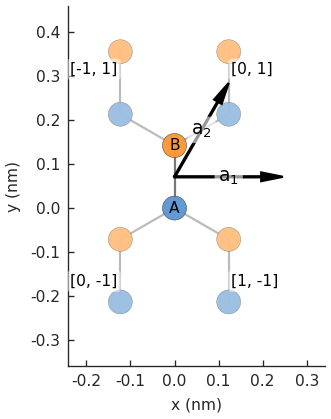

In [30]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt, pi

def monolayer_graphene(a = 0.24595, d_CC = 0.142, t = -2.8):
    '''
    input:
    a = 0.24595   # [nm] unit cell length
    a_cc = 0.142  # [nm] carbon-carbon distance
    t = -2.8      # [eV] nearest neighbour hopping
    '''

    lat = pb.Lattice(a1=[a, 0],
                     a2=[a/2, a* sqrt(3)/2])
    lat.add_sublattices(('A', [0, 0]),
                        ('B', [0, d_CC]))
    lat.add_hoppings(
        # inside the main cell
        ([0,  0], 'A', 'B', t),
        # between neighboring cells
        ([1, -1], 'A', 'B', t),
        ([0, -1], 'A', 'B', t)
    )
    return lat

dCCg = 0.142 # [nm] carbon-carbon distance in graphene
ag = 0.24595 # [nm] unit cell length
tCC = -2.8   # [eV] nearest neighbour hopping
Glattice = monolayer_graphene(ag, dCCg, tCC)
Glattice.plot()
plt.show()

<div class="intro">

The [`Lattice.add_sublattices()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.add_sublattices) method creates atoms A and B (blue and orange) at different offsets: $[0, -a_{cc}/2]$ and $[0, a_{cc}/2]$. Once again, the translated cells are given at positions $\vec{R} = n_1 \vec{a}_1 + n_2 \vec{a}_2$, however, this time the lattice vectors are not perpendicular which makes the integer indices $[n_1, n_2]$ slightly more complicate (see the labels in the figure).

The hoppings are defined as follows:

* `([0,  0], 'A', 'B', t)` specifies the hopping inside the main cell, from atom A to B. The main [0,0] cell is never labeled in the figure, but it is always the central cell where the lattice vectors originate.
  
* `([1, -1], 'A', 'B', t)` specifies the hopping between [0, 0] and [1, -1], from A to B. The opposite hopping is added automatically: [-1, 1], from B to A. In the tight-binding matrix representation, the opposite hopping is the Hermitian conjugate of the first one. The lattice specification always requires explicitly mentioning only one half of the hoppings while the other half is automatically added to guarantee hermiticity.
  
* `([0, -1], 'A', 'B', t)` is handled in the very same way.
  
The [`Lattice.plot()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.plot) method will always faithfully draw any lattice that has been specified. It serves as a handy visual inspection tool.

</div>


### Brillouin zone

<div class="intro">

The method [`Lattice.plot_brillouin_zone()`](http://docs.pybinding.site/page/tutorial/../_api/pybinding.Lattice.html#pybinding.Lattice.plot_brillouin_zone) is another handy tool that does just as its name implies.

</div>

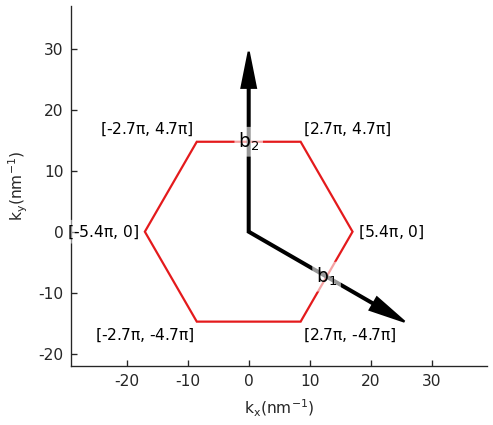

In [31]:
Glattice.plot_brillouin_zone()

### Band structure calculation

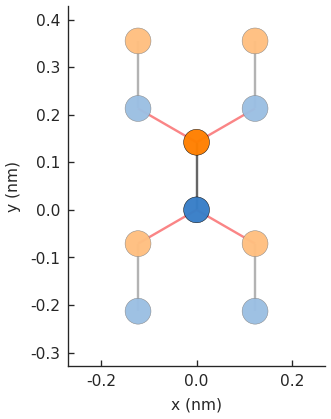

In [32]:
Gmodel = pb.Model(Glattice,
          pb.translational_symmetry()
)
Gmodel.plot()

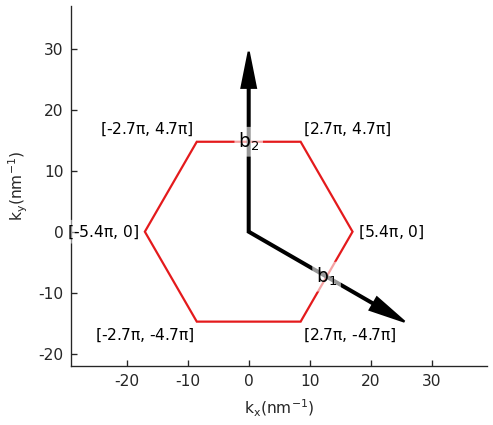

In [37]:
Gsolver = pb.solver.lapack(Gmodel)

Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*dCCg), 0]
M = [0, 2*pi / (3*dCCg)]
K2 = [2*pi / (3*sqrt(3)*dCCg), 2*pi / (3*dCCg)]

kpLabels = point_labels=['K1', f'$\Gamma$', 'M', 'K2']

Gmodel.lattice.plot_brillouin_zone(decorate=True)
plt.show()
Gbands = Gsolver.calc_bands(K1, Gamma, M, K2)

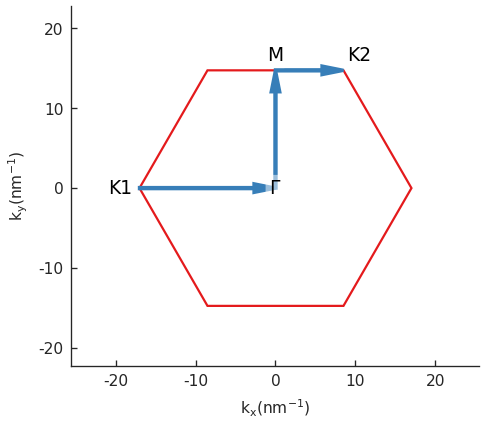

In [39]:
Gmodel.lattice.plot_brillouin_zone(decorate=False)
Gbands.plot_kpath(point_labels=kpLabels)

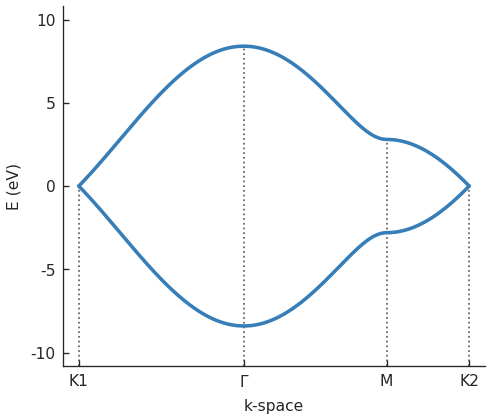

In [40]:
Gbands.plot(point_labels=kpLabels)

<div class="rq">

Graphene is a [zero-gap semiconductor](https://en.wikipedia.org/wiki/Electronic_properties_of_graphene), because its conduction and valence bands meet at Dirac points, *i.e.* the meeting points of two [Dirac cones](https://en.wikipedia.org/wiki/Dirac_cone).
</div>

# Useful links and bibliography

[Tight-binding method on wikipedia](https://en.wikipedia.org/wiki/Tight_binding)

[Roald Hoffmann, How Chemistry and Physics Meet in the Solid State (1987), *Angew. Chem. Int. Ed.* **26**:846-878, 10.1002/anie.198708461](http://doi.org/10.1002/anie.198708461)

[R. Hoffmann (1991), Solids And Surfaces. A Chemist's View of Bonding in Extended Structures, Wiley-VCH](https://www.wiley.com/en-us/Solids+and+Surfaces%3A+A+Chemist%27s+View+of+Bonding+in+Extended+Structures-p-9781119815143)

In [37]:
vID.end(cwd0)

**End at:** Tuesday 14 November 2023, 20:52:19  
**Duration:** 01:39:00 210ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>